In [231]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [232]:
import pandas as pd
import numpy as np
import seaborn as sns

In [233]:
import os
import cv2
import random

In [234]:
TRAIN_DIR = 'input/stage1_train/'
TEST_DIR = 'input/stage1_test/'
WIDTH = 128
HEIGHT = 128
CHANNEL = 3

In [235]:
test_ids = os.listdir('input/stage1_test')

In [236]:
X_test = []
sizes_test = []
for d in test_ids:
    base_path = os.path.join(TEST_DIR, d)
    img = cv2.imread(os.path.join(base_path,"images",d+".png"))
    sizes_test.append([img.shape[0], img.shape[1]])
    img = cv2.resize(img,(HEIGHT,WIDTH))/255
    X_test.append(img)
    
X_test = np.array(X_test)

In [237]:
X_test.shape

(65, 128, 128, 3)

In [238]:
import tensorflow as tf
from keras import backend as K
from keras.models import load_model

In [239]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [315]:
model = load_model('model_02.h5', custom_objects={'mean_iou': mean_iou})
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(cv2.resize(np.squeeze(preds_test[i]),(sizes_test[i][1], sizes_test[i][0])))

65/65 [==============================] - 1s 11ms/step


In [316]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

from skimage.morphology import label
def prob_to_rles(x, cutoff=0.2):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [317]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [318]:
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))
sub.to_csv('sub_01.csv', index=False)

([], <a list of 0 Text yticklabel objects>)

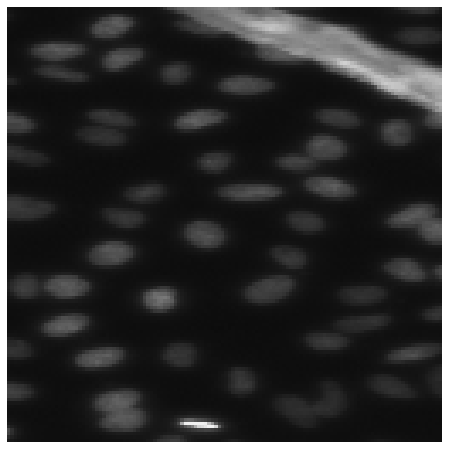

In [330]:
ix = 1
plt.figure(figsize=(8,8))
plt.imshow(X_test[ix])
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

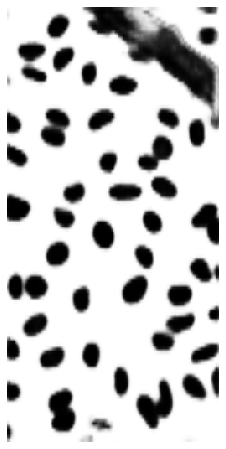

In [331]:
plt.figure(figsize=(8,8))
plt.imshow(preds_test_upsampled[ix])
plt.xticks([])
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

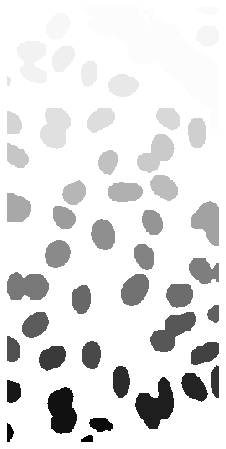

In [380]:
lab_img = label(preds_test_upsampled[ix]> 0.2)

plt.figure(figsize=(8,8))
plt.imshow(lab_img)
plt.xticks([])
plt.yticks([])

In [359]:
lab_img.max()

48

In [397]:
dot_size=[]
for i in  range(1, lab_img.max() + 1):
    dots = np.where(lab_img.flatten() == i)[0]
    dot_size.append(len(dots))

In [401]:
dot_size = np.array(dot_size)
dot_size.mean()

870.89583333333337

In [407]:
dot_size.mean()-dot_size.std(),dot_size.mean()+dot_size.std()

(-308.05987052042281, 2049.8515371870894)

In [408]:
dot_size

array([8569,  192,  673,  523, 1287,  627,  503,  759,   47, 1328,  704,
        582,  407,  642, 1201,  551,  523,  731,  608,  825,  831, 1181,
        581,  596,  836,  795,  589,  811, 1355,  949,  747,  637,  234,
        732, 1410,  403,  621,  676,  724,  318,  623,  742, 1693,  381,
       1462,  366,  132,   96])